<a href="https://colab.research.google.com/github/sam134-eng/INM706-Sequence-analysis/blob/main/Sentiment_Analysis_Test2_GloVe_FIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb --quiet

import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samraggig55 (samraggig55-city-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
!pip install nltk
import nltk
nltk.download('punkt')

import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("Tweets.csv")
df = df[['text', 'airline_sentiment']]
df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]
df['label'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df["clean_text"] = df["text"].apply(clean_text)


Saving Tweets.csv to Tweets.csv


In [4]:
!pip install nltk
import nltk
# Download the necessary NLTK resources, including punkt_tab
nltk.download('punkt')
nltk.download('punkt_tab')

import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch


# First, tokenize the cleaned text
df['tokens'] = df['clean_text'].apply(word_tokenize)

# Create a vocabulary and word-to-index mapping
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab = Counter(all_tokens)
# Add a padding token at index 0
word_to_index = {'<pad>': 0}
word_to_index.update({word: i + 1 for i, (word, _) in enumerate(vocab.most_common())})

# Convert tokens to indices
df['indexed_tokens'] = df['tokens'].apply(lambda tokens: [word_to_index.get(token, word_to_index.get('<unk>', 0)) for token in tokens])

# Pad the sequences
# Determine the maximum sequence length
max_seq_length = max(len(x) for x in df['indexed_tokens'])

# Pad or truncate sequences to the maximum length
def pad_sequences(sequences, maxlen, padding='post', value=0):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            if padding == 'post':
                padded_seq = seq + [value] * (maxlen - len(seq))
            else: # padding == 'pre'
                 padded_seq = [value] * (maxlen - len(seq)) + seq
        else:
            padded_seq = seq[:maxlen]
        padded_sequences.append(padded_seq)
    return torch.tensor(padded_sequences, dtype=torch.long)

X = pad_sequences(df['indexed_tokens'], max_seq_length)
y = torch.tensor(df['label'].values, dtype=torch.long)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create DataLoader instances
train_loader = DataLoader(SentimentDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(SentimentDataset(X_test, y_test), batch_size=32)

# Sanity check: Ensure indices are within embedding range
# Use X instead of encoded_texts, as X contains the padded indexed tokens
max_id = X.max().item()
print(f"Max token index: {max_id}, Vocab size: {len(vocab)}")

Max token index: 12559, Vocab size: 12559


In [6]:
# implement GloVe Embedding Integration
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

embedding_dim = 100
glove_path = "glove.6B.100d.txt"

glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype='float32')
        glove_embeddings[word] = vector

# Change here: Use len(word_to_index) for the embedding matrix size
embedding_matrix = np.zeros((len(word_to_index), embedding_dim))
# Iterate through word_to_index to correctly map words to indices
for word, idx in word_to_index.items():
    # Skip the padding token as its vector is already initialized to zeros
    if word != '<pad>':
        vector = glove_embeddings.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector

--2025-05-25 12:32:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-25 12:32:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-25 12:32:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
# Install and initialize Weights & Biases
!pip install wandb --quiet

import wandb
wandb.login()

wandb.init(
    project="Sentiment-LSTM-GloVe",
    name="Test2_LSTM_GloVe",
    config={
        "embedding": "GloVe",
        "model": "LSTM",
        "hidden_dim": 128,
        "dropout": 0.3,
        "batch_size": 64,
        "learning_rate": 0.001,
        "epochs": 10
    }
)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Compute Class Weights ---
# These weights help handle class imbalance by penalizing underrepresented classes more.

# Get the unique classes actually present in y_train
# Convert y_train to numpy array and get unique values
unique_classes_in_y_train = np.unique(y_train.cpu().numpy())

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=unique_classes_in_y_train,  # Use unique classes from y_train
                                     y=y_train.cpu().numpy()) # Convert y_train to a NumPy array
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define weighted loss criterion
criterion = nn.CrossEntropyLoss(weight=weights)

# --- 2. Define Bidirectional LSTM Classifier ---
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, embedding_matrix):
        super(LSTMClassifier, self).__init__()

        # Load pre-trained embeddings, allow tuning (freeze=False)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=0)

        # Bidirectional LSTM with 2 layers and dropout
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True  # ✅ Make LSTM bidirectional
        )

        # Fully connected layer expects hidden_dim * 2 due to bidirectionality
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embed_dim)
        _, (hidden, _) = self.lstm(x)  # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)

        # For bidirectional: concatenate top layer forward and backward hidden states
        forward_hidden = hidden[-2]  # Forward direction
        backward_hidden = hidden[-1] # Backward direction
        combined = torch.cat((forward_hidden, backward_hidden), dim=1)  # Shape: (batch_size, hidden_dim * 2)

        return self.fc(combined)

# --- 3. Instantiate and Train the Model ---
# Create the model
model = LSTMClassifier(len(word_to_index), 100, 128, 3, embedding_matrix).to(device) # Corrected vocab_size
                                                                                     # to use len(word_to_index)
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model is now ready to be trained using your existing training loop.

Epoch 1: Loss = 0.7687, Accuracy = 0.6716
Epoch 2: Loss = 0.5412, Accuracy = 0.7893
Epoch 3: Loss = 0.4280, Accuracy = 0.8409
Epoch 4: Loss = 0.3355, Accuracy = 0.8799
Epoch 5: Loss = 0.2590, Accuracy = 0.9122
Epoch 6: Loss = 0.2049, Accuracy = 0.9308
Epoch 7: Loss = 0.1679, Accuracy = 0.9439
Epoch 8: Loss = 0.1342, Accuracy = 0.9551
Epoch 9: Loss = 0.1275, Accuracy = 0.9614
Epoch 10: Loss = 0.1010, Accuracy = 0.9658


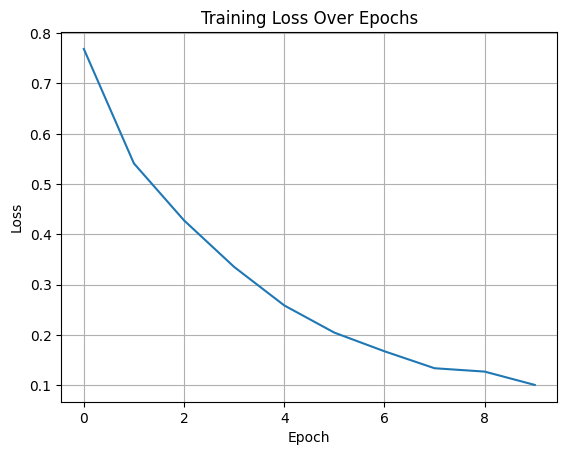

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.96585
train_loss,0.10101


In [10]:
import wandb
import matplotlib.pyplot as plt

# Optional: Log model architecture as a config
wandb.init(
    project="Sentiment-LSTM-GloVe",
    name="Test2_LSTM_GloVe",
    config={
        "model": "LSTM",
        "embedding": "GloVe",
        "hidden_dim": 128,
        "dropout": 0.3,
        "batch_size": 64,
        "learning_rate": 0.001,
        "epochs": 10
    }
)

train_losses = []
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    # 🟢 Log to WandB
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "train_accuracy": accuracy
    })

# Final loss curve
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 🟢 Finish WandB session
wandb.finish()


In [12]:
# file: ipython-input-11-98c7c1cf20f5
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb # Import wandb here if not already imported in this cell

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"], output_dict=True)

# 🟢 Log class-wise performance and overall metrics to WandB
# This wandb.log will now work because wandb.init() was called earlier
# and wandb.finish() hasn't been called yet.
wandb.log({
    "test_accuracy": report['accuracy'],
    "f1_macro": report['macro avg']['f1-score'],
    "f1_negative": report['Negative']['f1-score'],
    "f1_neutral": report['Neutral']['f1-score'],
    "f1_positive": report['Positive']['f1-score'],
    "precision_positive": report['Positive']['precision'],
    "recall_positive": report['Positive']['recall']
})

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot and log confusion matrix to WandB
fig = plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix - LSTM with GloVe")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

# 🟢 Log confusion matrix as an image
wandb.log({"Confusion Matrix": wandb.Image(fig)})

# Show confusion matrix plot
plt.show()

# 🟢 Finish WandB session here, after all logging is done for this run
# This will end the WandB run started by the initial wandb.init() call.
wandb.finish()

Error: You must call wandb.init() before wandb.log()

In [13]:
# ipython-input-10-6c7cfab2f167
import wandb
import matplotlib.pyplot as plt

# Optional: Log model architecture as a config
# REMOVED: This wandb.init() call is a duplicate and causes the run to be finished too early.
# wandb.init(
#     project="Sentiment-LSTM-GloVe",
#     name="Test2_LSTM_GloVe",
#     config={
#         "model": "LSTM",
#         "embedding": "GloVe",
#         "hidden_dim": 128,
#         "dropout": 0.3,
#         "batch_size": 64,
#         "learning_rate": 0.001,
#         "epochs": 10
#     }
# )

train_losses = []
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    # 🟢 Log to WandB
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "train_accuracy": accuracy
    })

# Final loss curve
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# REMOVED: wandb.finish() should be called after all logging is complete, including evaluation.
# wandb.finish()

Epoch 1: Loss = 0.0824, Accuracy = 0.9746


Error: You must call wandb.init() before wandb.log()